In [1]:
import sys
import os

# Make parent dir importable and move working dir one level up 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
os.chdir("..")

import torch
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from train_prob_unet_model import get_args
from prob_unet import ProbabilisticUNet
import climex_utils as cu

plt.rcParams["figure.figsize"] = (6,4)
print("Working directory:", os.getcwd())

Working directory: /home/maalih@labos.polymtl.ca/prob-unet-mds


In [2]:

args = get_args()
args.lowres_scale = 16
args.batch_size = 32


dataset_test = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_test,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_residuals",
    transfo=True
)

# 4) Create the test DataLoader
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)


print("Test samples:", len(dataset_test), "| Batch size:", args.batch_size)
print("Variables:", args.variables)



Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Test samples: 3650 | Batch size: 32
Variables: ['pr', 'tasmin', 'tasmax']


In [3]:
def invert_transfo_3vars(data_3ch: torch.Tensor) -> torch.Tensor:
    """
    data_3ch shape: [*, 3, H, W] in the same 'transfo' domain as stored in dataset.
    Returns the real-domain [*, 3, H, W] in mm/day (for pr) and °C (for tasmin, tasmax).
    """
    # Imports from climex_utils
    from climex_utils import softplus, softplus_inv, kgm2sTommday, KToC

    # Ensure we work in float
    data_3ch = data_3ch.float()

    # Split the three variables
    pr_stored    = data_3ch[:, 0, ...]  # shape [* , H, W]
    tasmin_stored= data_3ch[:, 1, ...]
    tasmax_stored= data_3ch[:, 2, ...]

    # 1) Precip => pr_real in mm/day
    pr_real = kgm2sTommday( softplus(pr_stored) )

    # 2) tasmin => in Kelvin originally, so we just do KToC
    tasmin_real = KToC(tasmin_stored)

    # 3) tasmax => we stored softplus_inv(tasmax - tasmin). 
    #    Invert => tasmax = softplus(tasmax_stored) + tasmin_stored
    #    Then convert from K to °C
    tasmax_real = KToC( softplus(tasmax_stored) + tasmin_stored )

    # Re-stack
    return torch.stack([pr_real, tasmin_real, tasmax_real], dim=1)

In [4]:
# ------------------------------------------------------------
# 2) Low-level PSD of a single 2-D field
# ------------------------------------------------------------
def psd(image2d: torch.Tensor):
    """
    Compute azimuthally-averaged 2-D power spectral density.

    image2d : torch.Tensor [H,W]  (real domain; NOT batched)
    Returns  : k (spatial wavenumber)  and  P(k)
    """
    H, W = image2d.shape
    fourier = torch.fft.fftn(image2d)
    power   = torch.abs(fourier) ** 2         # |F(k)|²

    # Radial frequency grid
    kfreq = torch.fft.fftfreq(H) * H
    kx, ky = torch.meshgrid(kfreq, kfreq, indexing='ij')
    kr     = torch.sqrt(kx**2 + ky**2).flatten().cpu().numpy()
    powerf = power.flatten().cpu().numpy()

    kbins = np.arange(0.5, H//2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    psd_vals, _, _ = stats.binned_statistic(
        kr, powerf, statistic="mean", bins=kbins
    )
    psd_vals *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)   # 2-D shell area
    return kvals, psd_vals

# ------------------------------------------------------------
# 3) PSD over a 4-D or 5-D tensor
#    hr            : [T, 3, H, W]
#    preds         : [T, M, 3, H, W]   (optional ensemble dim)
#    transfo == True  →  data still in stored-transform space
# ------------------------------------------------------------
def compute_psd_tensor(data: torch.Tensor, transfo: bool):
    """
    Returns dict {'pr': P(k), 'tasmin': P(k), 'tasmax': P(k)}
    averaged over all time steps (and ensemble members if present).
    """
    # bring to (N, 3, H, W) where N = T  or  (T*M)
    if data.dim() == 5:                                 # predictions
        T, M, C, H, W = data.shape
        data_use = data.reshape(T*M, C, H, W)
    else:                                               # ground truth
        data_use = data

    psd_acc = {'pr': [], 'tasmin': [], 'tasmax': []}

    for sample in data_use:            # iterate over N samples
        # undo transforms if needed
        s = sample.clone()
        if transfo:
            s[0] = cu.softplus(s[0])                                   # pr
            s[2] = cu.softplus(s[2], c=0) + s[1]                       # tasmax

        # now convert to real units
        s[0] = cu.kgm2sTommday(s[0])
        s[1] = cu.KToC(s[1])
        s[2] = cu.KToC(s[2])

        for idx, key in enumerate(['pr', 'tasmin', 'tasmax']):
            _, p = psd(s[idx])
            psd_acc[key].append(p)

    # mean over samples → array length ~H/2 for every var
    return {k: np.mean(np.stack(v, axis=0), axis=0) for k, v in psd_acc.items()}

In [5]:

# We'll iterate over dataloader once to cache GT in transfo domain (no model yet).

all_hr_transformed = []

with torch.no_grad():
    for batch in dataloader_test:
        hr_trans = batch['hr']  # [B, 3, H, W], still transfo domain
        all_hr_transformed.append(hr_trans.numpy())

all_hr_trans_torch = torch.from_numpy(np.concatenate(all_hr_transformed, axis=0))  # [T, 3, H, W]

# k-axis from a representative field
kvals, _ = psd(all_hr_trans_torch[0, 0])
print("Cached GT (transfo) shape:", tuple(all_hr_trans_torch.shape))



Computing statistics for standardization
Cached GT (transfo) shape: (3650, 3, 128, 128)


In [6]:

def load_probunet(model_path: str) -> ProbabilisticUNet:
    model = ProbabilisticUNet(
        input_channels=len(args.variables),
        num_classes=len(args.variables),
        latent_dim=16,
        num_filters=[32, 64, 128, 256],
        model_channels=32,
        channel_mult=[1, 2, 4, 8],
        beta_0=0.0,
        beta_1=0.0,
        beta_2=0.0
    ).to(args.device)

    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    state_dict = torch.load(model_path, map_location=args.device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def predict_ensemble_transfo(model: ProbabilisticUNet, dataloader, num_samples: int = 15):
    """
    Returns predictions in transfo domain with shape [T, M, 3, H, W],
    where T = total samples across dataloader, M = ensemble size.
    """
    preds_all_batches = []
    with torch.no_grad():
        for batch in dataloader:
            inputs     = batch['inputs'].to(args.device)       # [B, 3, H, W] (transfo)
            lrinterp   = batch['lrinterp']                     # used to reconstruct HR from residuals
            timestamps = batch['timestamps'].unsqueeze(1).to(args.device)

            ens = []
            for _ in range(num_samples):
                out_residual = model(inputs, target=None, t=timestamps, training=False)  # [B, 3, H, W] residual (transfo)
                out_hr_trans = dataloader.dataset.residual_to_hr(out_residual.cpu(), lrinterp)  # [B, 3, H, W] transfo
                ens.append(out_hr_trans.numpy())
            ens = np.stack(ens, axis=1)  # (B, M, 3, H, W)
            preds_all_batches.append(ens)

    preds = np.concatenate(preds_all_batches, axis=0)  # (T, M, 3, H, W)
    return torch.from_numpy(preds)


In [7]:
models_info = [
    ("./results/plots/08/01/202508:49:05/probunet_model_lat_dim_16.pth", "lambda-0"),       # WMSE-MSSSIM-lambda-0
    ("./results/plots/08/01/202508:23:04/probunet_model_lat_dim_16.pth", "lambda-1"),       # WMSE-MSSSIM-lambda-1
    ("./results/plots/07/22/202512:51:39/probunet_model_lat_dim_16.pth", "lambda-0.158"),   # WMSE-MSSSIM-lambda-0.158
    ("./results/plots/08/17/202515:50:03/probunet_model_lat_dim_16.pth", "afCRPS"),         # AFCRPS
]
print("\n".join([f"{lab}: {p}" for p, lab in models_info]))


lambda-0: ./results/plots/08/01/202508:49:05/probunet_model_lat_dim_16.pth
lambda-1: ./results/plots/08/01/202508:23:04/probunet_model_lat_dim_16.pth
lambda-0.158: ./results/plots/07/22/202512:51:39/probunet_model_lat_dim_16.pth
afCRPS: ./results/plots/08/17/202515:50:03/probunet_model_lat_dim_16.pth


In [8]:
#  compute PSDs for GT and models 
psd_gt = compute_psd_tensor(all_hr_trans_torch, transfo=True)

num_samples = 15  # ensemble size per model
psd_by_model = {}

for path, label in models_info:
    print(f"Running predictions for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=num_samples)
    psd_pred = compute_psd_tensor(preds_trans, transfo=True)
    psd_by_model[label] = psd_pred
    print(f"Done: {label}")


Running predictions for: lambda-0
Done: lambda-0
Running predictions for: lambda-1
Done: lambda-1
Running predictions for: lambda-0.158
Done: lambda-0.158
Running predictions for: afCRPS
Done: afCRPS


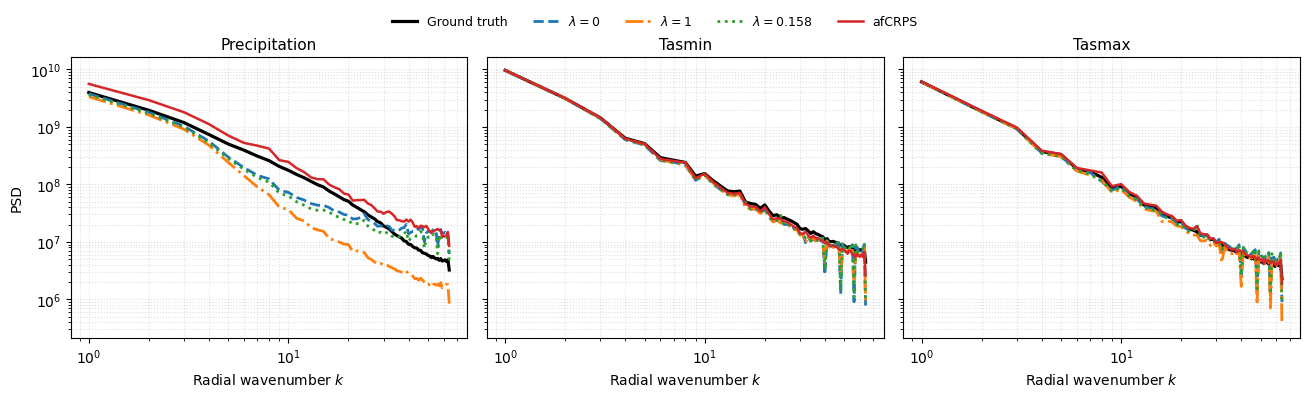

Saved: results/plots/08/18/202520:23:01/psd_comparison_3panel_4models.pdf


In [ ]:
from datetime import datetime
save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

var_names  = ['pr', 'tasmin', 'tasmax']
long_names = ['Precipitation', 'Tasmin', 'Tasmax']
units      = ['mm day⁻¹', '°C', '°C']

pretty_labels = {
    'lambda-0':     r'$\lambda=0$',
    'lambda-1':     r'$\lambda=1$',
    'lambda-0.158': r'$\lambda=0.158$',
    'afCRPS':       'afCRPS',
}

# Styles per model
model_styles = {
    'lambda-0':     dict(ls='--', lw=2),
    'lambda-1':     dict(ls='-.', lw=2),
    'lambda-0.158': dict(ls=':',  lw=2),
    'afCRPS':       dict(ls='-',  lw=1.8),
}

fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.8), sharex=True, sharey=True)

for ax, v, title, unit in zip(axes, var_names, long_names, units):
    # GT first
    ax.loglog(kvals, psd_gt[v], color='black', lw=2.3, label='Ground truth')

    # Models
    for key, style in model_styles.items():
        ax.loglog(kvals, psd_by_model[key][v], label=pretty_labels[key], **style)

    ax.set_title(title, fontsize=11)
    ax.grid(True, which='both', ls=':', alpha=0.4)

axes[0].set_xlim(1, 100)

axes[0].set_xlabel('Radial wavenumber $k$')
axes[1].set_xlabel('Radial wavenumber $k$')
axes[2].set_xlabel('Radial wavenumber $k$')
axes[0].set_ylabel('PSD')

# Unified legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, fontsize=9, bbox_to_anchor=(0.5, 1.05))

# plt.suptitle('Azimuthally-averaged Power Spectral Density\nGround truth vs. four Probabilistic U-Net variants', y=1.22, fontsize=13)
plt.tight_layout()
save_path = os.path.join(save_dir, "psd_comparison_3panel_4models.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {save_path}")

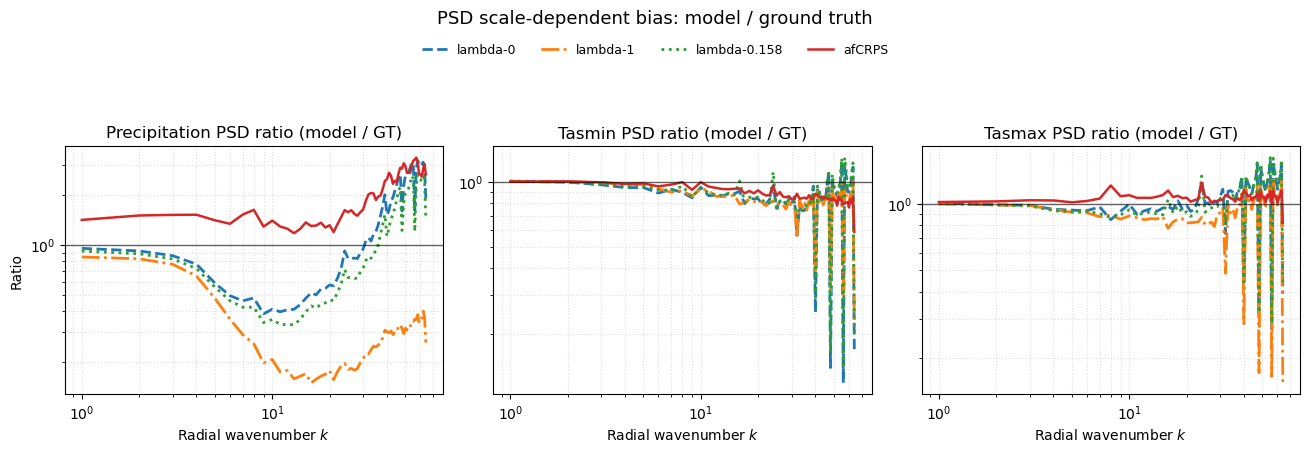

Saved: results/plots/08/18/202520:24:35/psd_ratio_3panel_4models.pdf


In [11]:
save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

make_ratio = True
if make_ratio:
    fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.8), sharex=True)
    for ax, v, title in zip(axes, ['pr', 'tasmin', 'tasmax'], ['Precipitation', 'Tasmin', 'Tasmax']):
        for label, style in model_styles.items():
            ratio = np.clip(psd_by_model[label][v] / (psd_gt[v] + 1e-12), 1e-6, 1e6)
            ax.loglog(kvals, ratio, label=label, **style)
        ax.axhline(1.0, color='black', lw=1, alpha=0.6)
        ax.set_title(f"{title} PSD ratio (model / GT)")
        ax.grid(True, which='both', ls=':', alpha=0.4)
    axes[0].set_xlabel('Radial wavenumber $k$')
    axes[1].set_xlabel('Radial wavenumber $k$')
    axes[2].set_xlabel('Radial wavenumber $k$')
    axes[0].set_ylabel('Ratio')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, fontsize=9, bbox_to_anchor=(0.5, 1.12))
    plt.suptitle('PSD scale-dependent bias: model / ground truth', y=1.18, fontsize=13)
    plt.tight_layout()
    save_path = os.path.join(save_dir, "psd_ratio_3panel_4models.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


In [9]:
def hr_trans_to_real(hr_trans: torch.Tensor) -> torch.Tensor:
    """
    hr_trans: (T, 3, H, W) in stored 'transfo' domain
    returns:  (T, 3, H, W) in real units
    """
    T = hr_trans.shape[0]
    out = []
    for i in range(T):
        out.append(invert_transfo_3vars(hr_trans[i:i+1]).squeeze(0))
    return torch.stack(out, dim=0)

def preds_trans_to_real(preds_trans: torch.Tensor) -> torch.Tensor:
    """
    preds_trans: (T, M, 3, H, W) in 'transfo' domain
    returns:     (T, M, 3, H, W) in real units
    """
    T, M, C, H, W = preds_trans.shape
    out_T = []
    for i in range(T):
        out_M = []
        for m in range(M):
            out_M.append(invert_transfo_3vars(preds_trans[i, m:m+1]).squeeze(0))
        out_T.append(torch.stack(out_M, dim=0))
    return torch.stack(out_T, dim=0)


In [13]:

from metrics import crps_over_groundtruth

# 1) Ground truth in REAL units (compute once)
all_hr_real = hr_trans_to_real(all_hr_trans_torch)  # (T, 3, H, W)

# 2) For each checkpoint: run predictions (TRANSFO), convert to REAL, compute CRPS
num_samples = 15
crps_by_model = {}

for path, label in models_info:  # same models_info you used for PSD
    print(f"CRPS pass for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=num_samples)  # (T, M, 3, H, W)
    preds_real  = preds_trans_to_real(preds_trans)                                           # (T, M, 3, H, W)
    crps_dict   = crps_over_groundtruth(all_hr_real, preds_real)
    crps_by_model[label] = crps_dict
    print(f"  pr={crps_dict['pr']:.4f}, tasmin={crps_dict['tasmin']:.4f}, tasmax={crps_dict['tasmax']:.4f}")

# 3) Pretty print as a small table
print("\n== Mean CRPS (lower is better) ==")
vars_order = ["pr", "tasmin", "tasmax"]
header = "model      " + "  ".join([f"{v:>10}" for v in vars_order])
print(header)
for label in crps_by_model:
    row = f"{label:<10} " + "  ".join([f"{crps_by_model[label][v]:10.4f}" for v in vars_order])
    print(row)


Pysteps configuration file found at: /home/maalih@labos.polymtl.ca/anaconda3/envs/diffusion/lib/python3.12/site-packages/pysteps/pystepsrc

CRPS pass for: lambda-0
  pr=1.0727, tasmin=0.8571, tasmax=0.6823
CRPS pass for: lambda-1
  pr=1.1304, tasmin=0.7840, tasmax=0.5927
CRPS pass for: lambda-0.158
  pr=1.0588, tasmin=0.8502, tasmax=0.6593
CRPS pass for: afCRPS
  pr=0.9387, tasmin=0.6794, tasmax=0.6192

== Mean CRPS (lower is better) ==
model              pr      tasmin      tasmax
lambda-0       1.0727      0.8571      0.6823
lambda-1       1.1304      0.7840      0.5927
lambda-0.158     1.0588      0.8502      0.6593
afCRPS         0.9387      0.6794      0.6192


Histogram pass for: ssim-0
Histogram pass for: ssim-1
Histogram pass for: ssim-0.158
Histogram pass for: crps


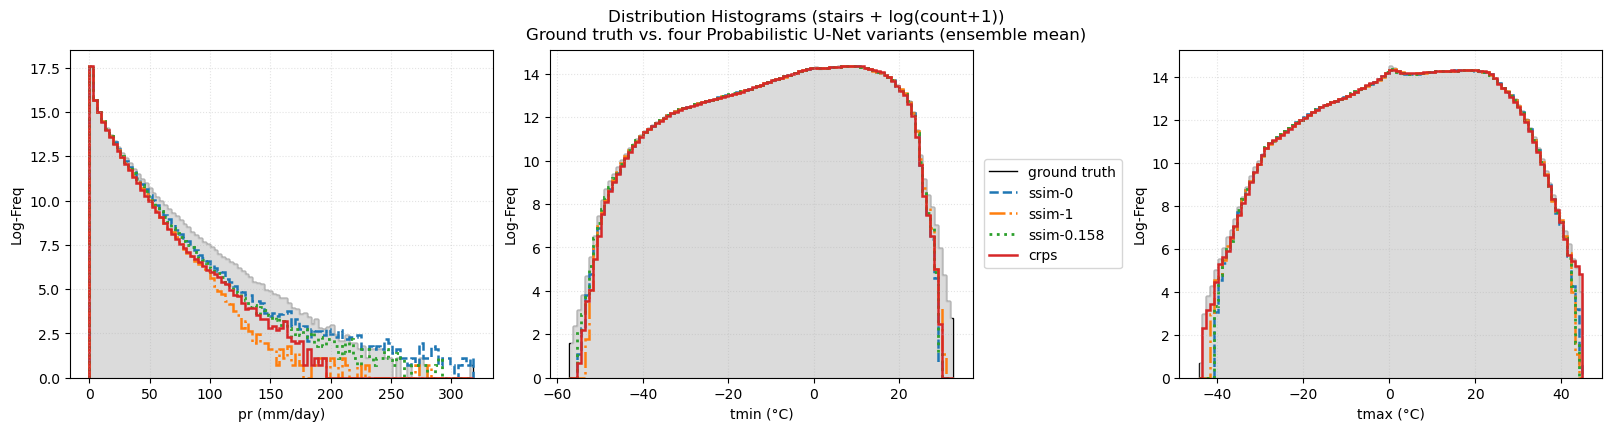

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

# Config — set to False if you want exact log(count) (beware of -inf when a bin is empty)
ADD_ONE_IN_LOG = True           # use log(count+1) for numerical robustness
NBINS_PER_VAR  = 100            
HIST_ENSEMBLE_MODE = 'ensemble_mean'   # or 'stack_ensemble'
LAYOUT = 'horizontal'           # 'horizontal' -> 1x3, 'vertical' -> 3x1
FILL_GT = True                  # fill grey under GT 


# 1) Ground truth in REAL units
all_hr_real = hr_trans_to_real(all_hr_trans_torch)   # (T, 3, H, W)
hr_np = all_hr_real.cpu().numpy()

# 2) Build predictions for each model (REAL units), summarized as requested
vals_by_model = {}  # label -> (T,3,H,W) numpy
for path, label in models_info:
    print(f"Histogram pass for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=15)  # (T,M,3,H,W)
    preds_real  = preds_trans_to_real(preds_trans).cpu().numpy()
    if HIST_ENSEMBLE_MODE == 'ensemble_mean':
        vals_by_model[label] = preds_real.mean(axis=1)                               # (T,3,H,W)
    elif HIST_ENSEMBLE_MODE == 'stack_ensemble':
        T, M, C, H, W = preds_real.shape
        vals_by_model[label] = preds_real.reshape(T*M, C, H, W)                      # (T*M,3,H,W)
    else:
        raise ValueError("HIST_ENSEMBLE_MODE must be 'ensemble_mean' or 'stack_ensemble'")

# 3) Bin edges from GT min/max (paper snippet style)
pr_min, pr_max = hr_np[:, 0].min(), hr_np[:, 0].max()
tmin_min, tmin_max = hr_np[:, 1].min(), hr_np[:, 1].max()
tmax_min, tmax_max = hr_np[:, 2].min(), hr_np[:, 2].max()

edges_pr   = np.linspace(pr_min,   pr_max,   NBINS_PER_VAR)
edges_tmin = np.linspace(tmin_min, tmin_max, NBINS_PER_VAR)
edges_tmax = np.linspace(tmax_min, tmax_max, NBINS_PER_VAR)
edges_list = [edges_pr, edges_tmin, edges_tmax]

var_names  = ["pr (mm/day)", "tmin (°C)", "tmax (°C)"]
var_idx    = [0, 1, 2]

# 4) Make figure
if LAYOUT == 'vertical':
    fig, axs = plt.subplots(3, 1, figsize=(20, 15), constrained_layout=True)
else:
    fig, axs = plt.subplots(1, 3, figsize=(16, 4.2), constrained_layout=True)
    axs = np.ravel(axs)

# style map
model_styles = {
    'ssim-0':     dict(ls='--', lw=1.8),
    'ssim-1':     dict(ls='-.', lw=1.8),
    'ssim-0.158': dict(ls=':',  lw=2.0),
    'crps':       dict(ls='-',  lw=1.8),
}

def log_counts(arr, edges):
    counts, edges_out = np.histogram(arr, bins=edges, density=False)
    if ADD_ONE_IN_LOG:
        y = np.log(counts + 1.0)
    else:
        # exact log(count); beware -inf for empty bins
        with np.errstate(divide='ignore'):
            y = np.log(counts)
    return y, edges_out

# 5) Plot per variable
for ax, vidx, vlabel, edges in zip(axs, var_idx, var_names, edges_list):
    # Ground truth
    gt_flat = hr_np[:, vidx].flatten()
    y_gt, e_gt = log_counts(gt_flat, edges)
    ax.stairs(y_gt, e_gt, color='black', label='ground truth')
    if FILL_GT:
        # make a filled version under the black outline for visual match
        # stairs returns edges; fill via step='post'
        mids = 0.5*(e_gt[:-1] + e_gt[1:])
        # approximate fill using step curve
        ax.fill_between(mids, y_gt, step='mid', color='lightgray', alpha=0.8)

    # Models
    for label, style in model_styles.items():
        arr = vals_by_model[label][:, vidx].reshape(-1)   # (T,H,W) -> vector (or (T*M,H,W)->vector)
        y_m, e_m = log_counts(arr, edges)
        ax.stairs(y_m, e_m, label=label, **style)

    ax.set_ylabel("Log-Freq")
    ax.set_xlabel(vlabel)
    ax.grid(True, which='both', ls=':', alpha=0.35)

# Legend
if LAYOUT == 'vertical':
    axs[0].legend()
else:
    axs[1].legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=True)

# title_mode = HIST_ENSEMBLE_MODE.replace('_', ' ')
# fig.suptitle(f"Distribution Histograms (stairs + log(count{'+1' if ADD_ONE_IN_LOG else ''}))\n"
#              f"Ground truth vs. four Probabilistic U-Net variants ({title_mode})")
save_path = os.path.join(save_dir, "dist_histograms.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


Histogram pass for: lambda-0
Histogram pass for: lambda-1
Histogram pass for: lambda-0.158
Histogram pass for: afCRPS


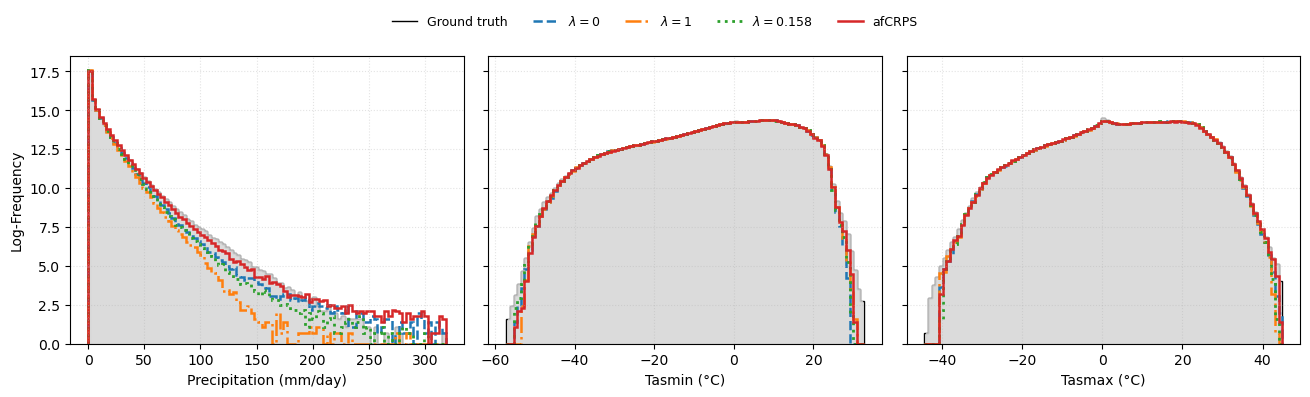

Saved: results/plots/08/18/202521:14:15/dist_histograms_styled.pdf


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Assume these variables and functions are defined from your environment:
# hr_trans_to_real, all_hr_trans_torch, models_info, load_probunet,
# predict_ensemble_transfo, preds_trans_to_real, dataloader_test

save_dir = os.path.join(
    "results", "plots",
    datetime.now().strftime("%m"),
    datetime.now().strftime("%d"),
    datetime.now().strftime("%Y%H:%M:%S")
)
os.makedirs(save_dir, exist_ok=True)

# Config — set to False if you want exact log(count) (beware of -inf when a bin is empty)
ADD_ONE_IN_LOG = True            # use log(count+1) for numerical robustness
NBINS_PER_VAR  = 100
HIST_ENSEMBLE_MODE = 'ensemble_mean'  # or 'stack_ensemble'
LAYOUT = 'horizontal'            # 'horizontal' -> 1x3, 'vertical' -> 3x1
FILL_GT = True                   # fill grey under GT

# 1) Ground truth in REAL units
all_hr_real = hr_trans_to_real(all_hr_trans_torch)  # (T, 3, H, W)
hr_np = all_hr_real.cpu().numpy()

# 2) Build predictions for each model (REAL units), summarized as requested
vals_by_model = {}  # label -> (T,3,H,W) numpy
for path, label in models_info:
    print(f"Histogram pass for: {label}")
    model = load_probunet(path)
    preds_trans = predict_ensemble_transfo(model, dataloader_test, num_samples=15)  # (T,M,3,H,W)
    preds_real  = preds_trans_to_real(preds_trans).cpu().numpy()
    if HIST_ENSEMBLE_MODE == 'ensemble_mean':
        vals_by_model[label] = preds_real.mean(axis=1)                          # (T,3,H,W)
    elif HIST_ENSEMBLE_MODE == 'stack_ensemble':
        T, M, C, H, W = preds_real.shape
        vals_by_model[label] = preds_real.reshape(T*M, C, H, W)                  # (T*M,3,H,W)
    else:
        raise ValueError("HIST_ENSEMBLE_MODE must be 'ensemble_mean' or 'stack_ensemble'")

# 3) Bin edges from GT min/max (paper snippet style)
pr_min, pr_max = hr_np[:, 0].min(), hr_np[:, 0].max()
tmin_min, tmin_max = hr_np[:, 1].min(), hr_np[:, 1].max()
tmax_min, tmax_max = hr_np[:, 2].min(), hr_np[:, 2].max()

edges_pr   = np.linspace(pr_min,   pr_max,   NBINS_PER_VAR)
edges_tmin = np.linspace(tmin_min, tmin_max, NBINS_PER_VAR)
edges_tmax = np.linspace(tmax_min, tmax_max, NBINS_PER_VAR)
edges_list = [edges_pr, edges_tmin, edges_tmax]

var_names  = ["Precipitation (mm/day)", "Tasmin (°C)", "Tasmax (°C)"]
var_idx    = [0, 1, 2]

# 4) Make figure with the requested size
# NOTE: Changed figsize and added sharey=True for consistency
fig, axs = plt.subplots(1, 3, figsize=(13.2, 3.8), sharey=True)
axs = np.ravel(axs)

# --- STYLING TO MATCH PSD PLOT ---
# NOTE: Using new labels and styles that match the models in this script
pretty_labels = {
    'lambda-0':     r'$\lambda=0$',
    'lambda-1':     r'$\lambda=1$',
    'lambda-0.158': r'$\lambda=0.158$',
    'afCRPS':       'afCRPS',
}

model_styles = {
    'lambda-0':     dict(ls='--', lw=1.8),
    'lambda-1':     dict(ls='-.', lw=1.8),
    'lambda-0.158': dict(ls=':',  lw=2.0),
    'afCRPS':       dict(ls='-',  lw=1.8),
}
# ------------------------------------

def log_counts(arr, edges):
    counts, edges_out = np.histogram(arr, bins=edges, density=False)
    if ADD_ONE_IN_LOG:
        y = np.log(counts + 1.0)
    else:
        # exact log(count); beware -inf for empty bins
        with np.errstate(divide='ignore'):
            y = np.log(counts)
    return y, edges_out

# 5) Plot per variable
for ax, vidx, vlabel, edges in zip(axs, var_idx, var_names, edges_list):
    # Ground truth
    gt_flat = hr_np[:, vidx].flatten()
    y_gt, e_gt = log_counts(gt_flat, edges)
    # NOTE: Changed label for consistency
    ax.stairs(y_gt, e_gt, color='black', label='Ground truth')
    if FILL_GT:
        mids = 0.5*(e_gt[:-1] + e_gt[1:])
        ax.fill_between(mids, y_gt, step='mid', color='lightgray', alpha=0.8)

    # Models
    for label, style in model_styles.items():
        arr = vals_by_model[label][:, vidx].reshape(-1)
        y_m, e_m = log_counts(arr, edges)
        # NOTE: Using pretty_labels for the legend
        ax.stairs(y_m, e_m, label=pretty_labels[label], **style)

    ax.set_xlabel(vlabel)
    ax.grid(True, which='both', ls=':', alpha=0.35)

# Set shared Y-axis label only on the first plot
axs[0].set_ylabel("Log-Frequency")


# --- UNIFIED LEGEND (from PSD plot) ---
# NOTE: Replaced the old legend code with this block
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, fontsize=9, bbox_to_anchor=(0.5, 1.05))
# ------------------------------------


# Use tight_layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95]) # rect adjusts for the fig.legend
save_path = os.path.join(save_dir, "dist_histograms_styled.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {save_path}")